# 5 Colors

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

In [2]:
def mse(A, B, ax=None):
    '''
    ax = 0: the average is performed along the row, for each column, returning an array
    ax = 1: the average is performed along the column, for each row, returning an array
    ax = None: the average is performed element-wise along the array, returning a scalar value
    '''
    return ((A - B)**2).mean(axis=ax)

In [127]:
def psnr(image, reference):
    image_float = np.float64(np.copy(image))
    reference_float = np.float64(np.copy(reference))
    pixel_max_value = 255.0

    mse_value = mse(image_float, reference_float)

    if mse_value == 0:
        return 100
    
    return 20 * math.log10(pixel_max_value / math.sqrt(mse_value))

## 5.1. Color Space

**5.1.1. Convert Pepper to HSI format, and display the HIS components as separate grayscale images. Observe these
images to comment on what does each of the H, S, I components represent. The HSI images should be saved in
double precision.**

In [4]:
src_path = './Images/5/Pepper.bmp'
src = cv2.imread(src_path)

In [6]:
blue = src[:, :, 0]
green = src[:, :, 1]
red = src[:, :, 2]

In [7]:
src_to_show = cv2.merge((red, green, blue))
src_to_show = Image.fromarray(src_to_show)

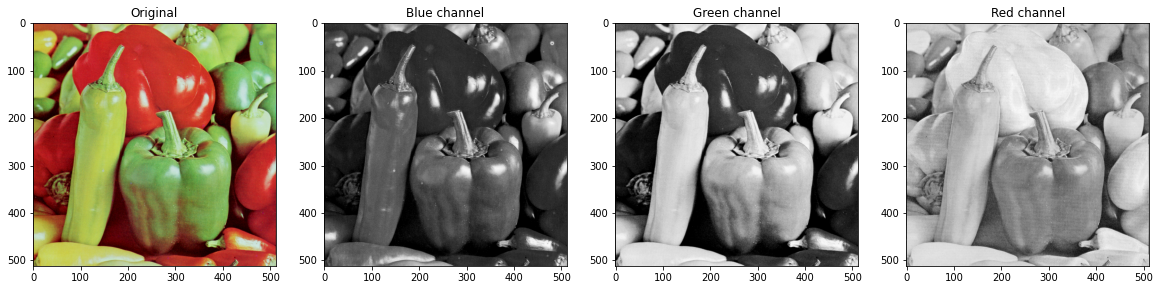

In [181]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src_to_show, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Blue channel")
plt.imshow(blue, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Green channel")
plt.imshow(green, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Red channel")
plt.imshow(red, cmap='gray')

In [161]:
def calculate_intensity(rgb):
    blue = rgb[:, :, 0]
    green = rgb[:, :, 1]
    red = rgb[:, :, 2]
    
    intensity = (red + green + blue) / 3.0
    return intensity * 255.0

In [162]:
def calculate_saturation(rgb):
    blue = rgb[:, :, 0]
    green = rgb[:, :, 1]
    red = rgb[:, :, 2]
    
    saturation = 1.0 - 3.0 * np.minimum(np.minimum(red, green), blue) / (red + green + blue + 1e-4)
    return saturation * 255.0

In [163]:
def calculate_hue(rgb):
    
    blue = rgb[:, :, 0]
    green = rgb[:, :, 1]
    red = rgb[:, :, 2]
    
    height, width = blue.shape
    hue = np.zeros_like(blue)
    
    for x in range(height):
        for y in range(width):
            arg = 0.5 * ((red[x, y] - green[x, y]) + (red[x, y] - blue[x, y])) / math.sqrt(
                (red[x, y] - green[x, y]) **2 + (red[x, y] - blue[x, y]) * (green[x, y] - blue[x, y]))
            theta = math.acos(arg)

            if blue[x, y] > green[x, y]:
                hue[x, y] = 2.0 * math.pi - theta
            else:
                hue[x, y] = theta
    
    hue /= (2.0 * math.pi)
    
    return hue * 255.0

In [132]:
def rgb_to_hsi(src):
    rgb = np.float64(src)
    
    rgb /= 255.0
    
    hue = calculate_hue(rgb)
    saturation = calculate_saturation(rgb)
    intensity = calculate_intensity(rgb)
    
    return hue, saturation, intensity

In [168]:
hue, saturation, intensity = rgb_to_hsi(src)

<ipython-input-163-9e2596fac224>:12: RuntimeWarning: invalid value encountered in double_scalars
  arg = 0.5 * ((red[x, y] - green[x, y]) + (red[x, y] - blue[x, y])) / math.sqrt(


In [171]:
cv2.imwrite('./Output Images/5/Hue.bmp', hue)
cv2.imwrite('./Output Images/5/Saturation.bmp', saturation)
cv2.imwrite('./Output Images/5/Intensity.bmp', intensity)

True

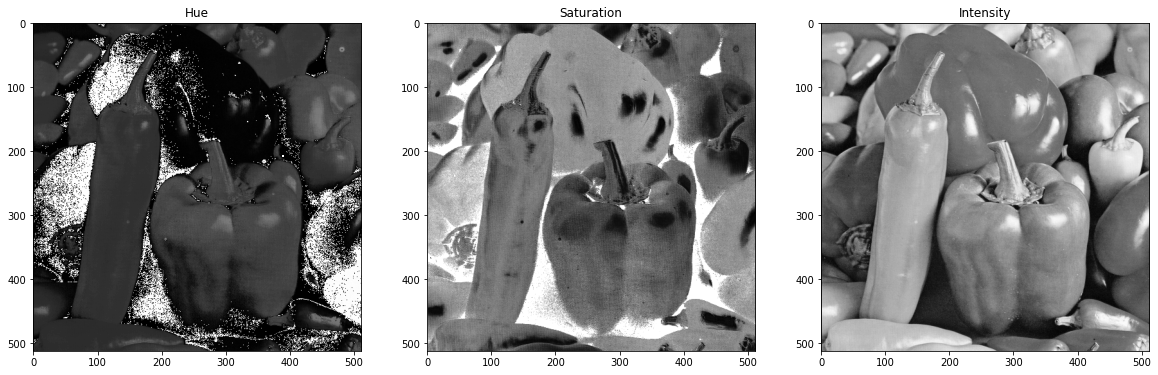

In [166]:
plt.figure(figsize=(20,10))

# plt.imshow(hsi / 255.0)

plt.subplot(1, 3, 1)
plt.title("Hue")
plt.imshow(hue, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Saturation")
plt.imshow(saturation, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Intensity")
plt.imshow(intensity, cmap='gray')

## 5.2. Quantization

**5.2.1. Implement uniform quantization of a color image. Your program should do the following:**

1. **Read a grayscale image into an array.**
2. **Quantize and save the quantized image in a different array.**
3. **Compute the MSE and PSNR between the original and quantized images.**
4. **Display and print the quantized image**

**Notice, your program should assume the input values are in the range of (0,256), but allow you to vary the
reconstruction level. Record the MSE and PSNR obtained with 𝐿 = 64, 32, 16, 8 and display the quantized images
with corresponding 𝐿 values. Comment on the image quality as you vary 𝐿. (Test on Pepper Image).**

In [46]:
src = cv2.imread(src_path)
blue = src[:, :, 0]
green = src[:, :, 1]
red = src[:, :, 2]

In [116]:
def uniform_quantize(src, num_levels):
    height, width = src.shape
    dst = np.zeros((height, width), dtype = np.uint8)
    
    max_index = np.where(src == src.max())
    min_index = np.where(src == src.min())
    
    max_value = src[max_index][0]
    min_value = src[min_index][0]
    
    dynamic_range = max_value - min_value
    Q = np.zeros(shape=(256, 1))
    step_size = dynamic_range / num_levels
    
    for i in range(256):
        Q[i, 0] = math.floor((i - min_value) / step_size) * step_size + step_size / 2 + min_value
    
    for x in range(height):
        for y in range(width):
            dst[x, y] = Q[src[x, y], 0]
    
    return dst

In [62]:
levels = [64, 32, 16, 8]

In [117]:
quantized_images = []
for i in range(len(levels)):
    current_level = levels[i]
    
    blue_quantized = uniform_quantize(blue, current_level)
    green_quantized = uniform_quantize(green, current_level)
    red_quantized = uniform_quantize(red, current_level)
    
    quantized = cv2.merge((blue_quantized, green_quantized, red_quantized))
    
    quantized_images.append(quantized)

In [118]:
quantized_64 = quantized_images[0]
quantized_32 = quantized_images[1]
quantized_16 = quantized_images[2]
quantized_8 = quantized_images[3]

In [124]:
mse_quantized_64 = mse(src, quantized_64)
mse_quantized_32 = mse(src, quantized_32)
mse_quantized_16 = mse(src, quantized_16)
mse_quantized_8 = mse(src, quantized_8)

In [128]:
psnr_quantized_64 = psnr(src, quantized_64)
psnr_quantized_32 = psnr(src, quantized_32)
psnr_quantized_16 = psnr(src, quantized_16)
psnr_quantized_8 = psnr(src, quantized_8)

In [120]:
blue_quantized_64 = quantized_64[:, :, 0]
green_quantized_64 = quantized_64[:, :, 1]
red_quantized_64 = quantized_64[:, :, 2]
quantized_64_to_show = cv2.merge((red_quantized_64, green_quantized_64, blue_quantized_64))

blue_quantized_32 = quantized_32[:, :, 0]
green_quantized_32 = quantized_32[:, :, 1]
red_quantized_32 = quantized_32[:, :, 2]
quantized_32_to_show = cv2.merge((red_quantized_32, green_quantized_32, blue_quantized_32))

blue_quantized_16 = quantized_16[:, :, 0]
green_quantized_16 = quantized_16[:, :, 1]
red_quantized_16 = quantized_16[:, :, 2]
quantized_16_to_show = cv2.merge((red_quantized_16, green_quantized_16, blue_quantized_16))

blue_quantized_8 = quantized_8[:, :, 0]
green_quantized_8 = quantized_8[:, :, 1]
red_quantized_8 = quantized_8[:, :, 2]
quantized_8_to_show = cv2.merge((red_quantized_8, green_quantized_8, blue_quantized_8))

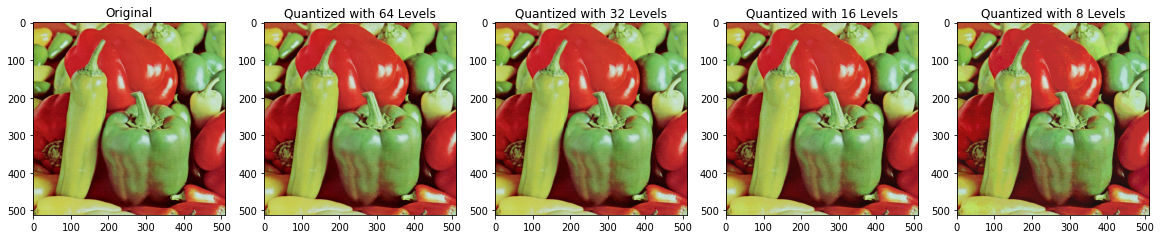

In [121]:
plt.figure(figsize=(20,10))

plt.subplot(1, 5, 1)
plt.title("Original")
plt.imshow(src_to_show)

plt.subplot(1, 5, 2)
plt.title("Quantized with 64 Levels")
plt.imshow(quantized_64_to_show)

plt.subplot(1, 5, 3)
plt.title("Quantized with 32 Levels")
plt.imshow(quantized_32_to_show)

plt.subplot(1, 5, 4)
plt.title("Quantized with 16 Levels")
plt.imshow(quantized_16_to_show)

plt.subplot(1, 5, 5)
plt.title("Quantized with 8 Levels")
plt.imshow(quantized_8_to_show)

In [122]:
cv2.imwrite('./Output Images/5/quantized_64.bmp', quantized_64)
cv2.imwrite('./Output Images/5/quantized_32.bmp', quantized_32)
cv2.imwrite('./Output Images/5/quantized_16.bmp', quantized_16)
cv2.imwrite('./Output Images/5/quantized_8.bmp', quantized_8)

True

###### Report MSE

In [125]:
data = {'L = 64': [mse_quantized_64],
        'L = 32': [mse_quantized_32],
        'L = 16': [mse_quantized_16],
        'L = 8': [mse_quantized_8]
        }

index =['Original']
df = pd.DataFrame(data, index=index)

In [126]:
df.head()

,L = 64,L = 32,L = 16,L = 8
Original,2.802339,6.586385,21.117748,75.784813


###### Report PSNR

In [129]:
data = {'L = 64': [psnr_quantized_64],
        'L = 32': [psnr_quantized_32],
        'L = 16': [psnr_quantized_16],
        'L = 8': [psnr_quantized_8]
        }

index =['Original']
df = pd.DataFrame(data, index=index)

In [130]:
df.head()

,L = 64,L = 32,L = 16,L = 8
Original,43.655597,39.944332,34.884328,29.207557


**5.2.2. For the Pepper image, quantize the R, G, and B components to 3, 3, and 2 bits, respectively, using a uniform
quantizer. Display the original and quantized color image. Comment on the difference in color accuracy.**

In [132]:
src = cv2.imread(src_path)
blue = src[:, :, 0]
green = src[:, :, 1]
red = src[:, :, 2]
src_to_show = cv2.merge((red, green, blue))

In [134]:
blue_quantized_4 = uniform_quantize(blue, 4)
green_quantized_8 = uniform_quantize(green, 8)
red_quantized_8 = uniform_quantize(red, 8)
quantized_884 = cv2.merge((blue_quantized_4, green_quantized_8, red_quantized_8))
quantized_884_to_show = cv2.merge((red_quantized_8, green_quantized_8, blue_quantized_4))

In [136]:
cv2.imwrite('./Output Images/5/quantized_884.bmp', quantized_884)

True

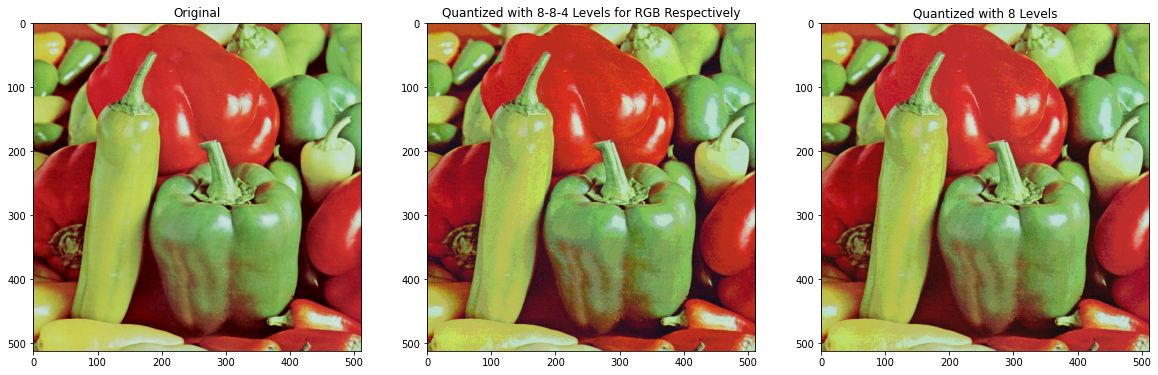

In [137]:
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(src_to_show)

plt.subplot(1, 3, 2)
plt.title("Quantized with 8-8-4 Levels for RGB Respectively")
plt.imshow(quantized_884_to_show)

plt.subplot(1, 3, 3)
plt.title("Quantized with 8 Levels")
plt.imshow(quantized_8_to_show)

###### Report MSE

In [138]:
data = {'L = 8-8-4 for RGB Respectively': [mse(src, quantized_884)]}
index =['Original']
df = pd.DataFrame(data, index=index)

In [139]:
df.head()

,L = 8-8-4 for RGB Respectively
Original,80.402917


###### Report PSNR

In [140]:
data = {'L = 8-8-4 for RGB Respectively': [psnr(src, quantized_884)]}
index =['Original']
df = pd.DataFrame(data, index=index)

In [141]:
df.head()

,L = 8-8-4 for RGB Respectively
Original,26.759238


**5.2.3. We want to weave the Girl image on a rug. To do so, we need to reduce the number of colors in the image with
minimal visual quality loss. If we can have 32, 16 and 8 different colors in the weaving process, reduce the color
of the image to these three special modes. Discuss and display the results.
Note: you can use immse and psnr for problem 5.2.**

In [142]:
src_path = './Images/5/Girl.bmp'
src = cv2.imread(src_path)
blue = src[:, :, 0]
green = src[:, :, 1]
red = src[:, :, 2]
src_to_show = cv2.merge((red, green, blue))

In [160]:
def kmeans_color_quantize(src, clusters=8, rounds=1):
    height, width, channels = src.shape
    samples = np.zeros([height * width, 3], dtype=np.float32)
    count = 0

    for x in range(height):
        for y in range(width):
            samples[count] = src[x, y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((src.shape))

In [161]:
src_reduced_8 = kmeans_color_quantize(src, clusters=8)
src_reduced_16 = kmeans_color_quantize(src, clusters=16)
src_reduced_32 = kmeans_color_quantize(src, clusters=32)

In [162]:
blue_reduced_32 = src_reduced_32[:, :, 0]
green_reduced_32 = src_reduced_32[:, :, 1]
red_reduced_32 = src_reduced_32[:, :, 2]
src_reduced_32_to_show = cv2.merge((red_reduced_32, green_reduced_32, blue_reduced_32))

blue_reduced_16 = src_reduced_16[:, :, 0]
green_reduced_16 = src_reduced_16[:, :, 1]
red_reduced_16 = src_reduced_16[:, :, 2]
src_reduced_16_to_show = cv2.merge((red_reduced_16, green_reduced_16, blue_reduced_16))

blue_reduced_8 = src_reduced_8[:, :, 0]
green_reduced_8 = src_reduced_8[:, :, 1]
red_reduced_8 = src_reduced_8[:, :, 2]
src_reduced_8_to_show = cv2.merge((red_reduced_8, green_reduced_8, blue_reduced_8))

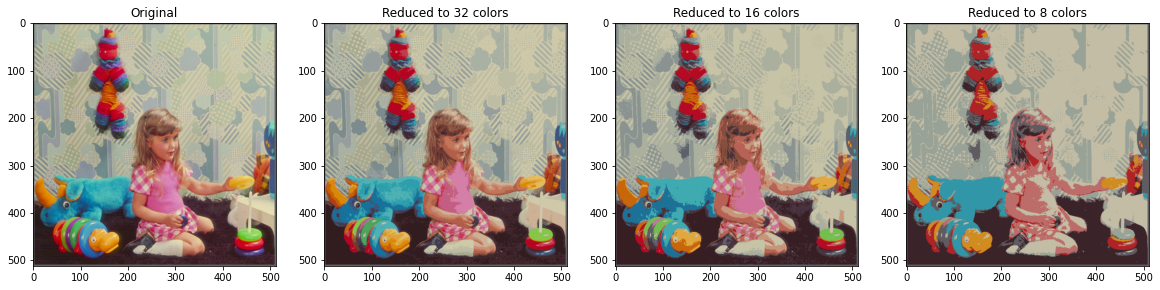

In [163]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src_to_show)

plt.subplot(1, 4, 2)
plt.title("Reduced to 32 colors")
plt.imshow(src_reduced_32_to_show)

plt.subplot(1, 4, 3)
plt.title("Reduced to 16 colors")
plt.imshow(src_reduced_16_to_show)

plt.subplot(1, 4, 4)
plt.title("Reduced to 8 colors")
plt.imshow(src_reduced_8_to_show)

In [164]:
cv2.imwrite('./Output Images/5/girl_32_colors.bmp', src_reduced_32)
cv2.imwrite('./Output Images/5/girl_16_colors.bmp', src_reduced_16)
cv2.imwrite('./Output Images/5/girl_8_colors.bmp', src_reduced_8)

True

###### Report MSE & PSNR

In [156]:
data = {'32 colors': [mse(src, src_reduced_32), psnr(src, src_reduced_32)],
        '16 colors': [mse(src, src_reduced_16), psnr(src, src_reduced_16)],
        '8 colors': [mse(src, src_reduced_8), psnr(src, src_reduced_8)],
       }
index =['Original MSE', 'Original PSNR']
df = pd.DataFrame(data, index=index)

In [157]:
df.head()

,32 colors,16 colors,8 colors
Original MSE,51.363452,63.986903,80.757079
Original PSNR,28.425962,25.828745,22.831135


## Resources

1. https://stackoverflow.com/questions/37575916/how-to-markdown-nested-list-items-in-bitbucket
2. https://stackoverflow.com/questions/12570859/how-to-show-pil-images-on-the-screen/12571366
3. https://stackoverflow.com/questions/22906394/numpy-ndarray-object-has-no-attribute-read
4. https://stackoverflow.com/questions/69434822/difference-between-pyplot-imshow-and-image-show?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+stackoverflow%2FynOn+%28Recent+Questions+-+Stack+Overflow%29
5. https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
6. https://stackoverflow.com/questions/55284090/how-to-find-maximum-value-in-whole-2d-array-with-indices